# ACSE-3 (Numerical Methods) <a class="tocSkip">

## Lecture 12: Finite element methods (FEM) 2 <a class="tocSkip">
    
### Homework exercises - solutions <a class="tocSkip">

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Homework" data-toc-modified-id="Homework-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Homework</a></span><ul class="toc-item"><li><span><a href="#Homework---Compare-solution-to-diffusion-with-homogeneous-vs-Dirichlet-BCs" data-toc-modified-id="Homework---Compare-solution-to-diffusion-with-homogeneous-vs-Dirichlet-BCs-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Homework - Compare solution to diffusion with homogeneous vs Dirichlet BCs</a></span><ul class="toc-item"><li><span><a href="#Solver---Compare-solution-to-diffusion-with-homogeneous-vs-Dirichlet-BCs" data-toc-modified-id="Solver---Compare-solution-to-diffusion-with-homogeneous-vs-Dirichlet-BCs-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Solver - Compare solution to diffusion with homogeneous vs Dirichlet BCs</a></span></li></ul></li><li><span><a href="#Homework---Laplacian-smoothing" data-toc-modified-id="Homework---Laplacian-smoothing-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Homework - Laplacian smoothing</a></span><ul class="toc-item"><li><span><a href="#Solution---Laplacian-smoothing" data-toc-modified-id="Solution---Laplacian-smoothing-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Solution - Laplacian smoothing</a></span></li></ul></li></ul></li></ul></div>

In [148]:
%precision 3
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sl
import scipy.sparse as sp
import scipy.sparse.linalg as spla
# the following allows us to plot triangles indicating convergence order
from mpltools import annotation
# as we're in 2D we will be doing some 3D plotting
from mpl_toolkits.mplot3d import Axes3D
# and using some colormaps
from matplotlib import cm
# and we will create some animations!
import matplotlib.animation as animation
from IPython.display import HTML
from pprint import pprint

# Homework


## Homework - Compare solution to diffusion with homogeneous vs Dirichlet BCs 

Use our 1D FEM based time-dependent diffusion solver to investigate the long time solution behaviour (i.e. what steady state does the solution tend to) for the diffusion problem in the cases of homogeneous Neumann and homogeneous Dirichlet boundary conditions. You can use the same Gaussian like initial condition from lecture.

Write some code to compute the area under the solution curve over the domain (i.e. the integral of the solution) in both cases and plot the evolution of this integral as a function of time - what do you notice?

### Solver - Compare solution to diffusion with homogeneous vs Dirichlet BCs 

We actually already have both BC options coded for us as options in `apply_bcs`. Just run both with a long end time. 

We see that with Neumann conditions the solution tends to a non-zero constant. While with Dirichlet it tends to zero everywhere. 

When plotting the integrals we see that with Neumann this integral is conserved - this is a proprty both of the exact solution with these BCs as well as the numerical solution (it's actually the time-stepping that leads to errors a little larger than machine precision - if we want to do better we need to couple the conservative spatial discretisation with a conservative time-stepping option

In [149]:
def generate_1D_CG_mesh(Lx, N_elements_CG, mesh_option=0):
    """ Function to generate a mesh given the domain size Lx
    (we assume the left hand entry is always at zero).
    
    Use N_elements_CG number of element.
    
    mesh_option==0 corresponds to a uniform mesh - only option implemented so far.
    
    Returns: the node locations x_node and the mesh spacing dx
    """
    if(mesh_option==0):
        x_nodes = np.linspace(0, Lx ,N_elements_CG+1)
    else:
        raise Exception('mesh_option != 0 not implemented yet')
    # given the mesh (somehow) compute an array of element sizes
    dx = np.diff(x_nodes)
    return x_nodes, dx

def connectivity(N_loc, N_elements_CG):
    """ Generate the connectivity matrix of dimension N_loc * N_elements_CG.
    
    Row corresponds to the local node number, column to the element number,
    the entry of the matrix is then a global node number.
    
    Returns: the connectivity matrix
    """
    connectivity_matrix = np.zeros((N_loc, N_elements_CG), dtype=int)
    if(N_loc==2):
        for element in range (N_elements_CG):
            connectivity_matrix[0, element] = element
            connectivity_matrix[1, element] = element + 1
    else:
        raise Exception('Only linear element (N_loc=2) implemented.')
    return connectivity_matrix

def shape(N_loc, N_gi):
    """ Define reference shape functions at N_gi quadrature points.
    Only implemented for N_loc = 2, i.e. two nodes per element - 
    linear basis functions.
    """ 
    assert(N_loc==2)
    phi = np.zeros((N_loc, N_gi))
    if(N_gi==2):
        phi[0,0] = 1.0 
        phi[0,1] = 0.0 
        phi[1,0] = 0.0 
        phi[1,1] = 1.0
    elif(N_gi==3):
        phi[0,0] = 1.0 
        phi[0,1] = 0.5 
        phi[0,2] = 0.0 
        phi[1,0] = 0.0 
        phi[1,1] = 0.5 
        phi[1,2] = 1.0        
    else:
        raise Exception('N_gi value not implemented.')
    return phi

def shape_derivatives(element, dx, N_loc, N_gi):
    """ Compute derivatives of shape functions.
    Only implemented for N_loc = 2, i.e. two nodes per element - 
    linear basis functions.
    """   
    assert(N_loc==2)
    phi_x = np.zeros((N_loc, N_gi))
    # the derivatives of our linear basis functions over the reference element
    if(N_gi==2):
        phi_x[0,0] = -1. / 2.
        phi_x[0,1] =  phi_x[0,0] 
        phi_x[1,0] = -phi_x[0,0]  
        phi_x[1,1] =  phi_x[1,0]
    elif(N_gi==3):
        phi_x[0,0] = -1. / 2.
        phi_x[0,1] = phi_x[0,0] 
        phi_x[0,2] = phi_x[0,0] 
        phi_x[1,0] = -phi_x[0,0] 
        phi_x[1,1] = phi_x[1,0] 
        phi_x[1,2] = phi_x[1,0]            
    else:
        raise Exception('N_gi value not implemented.')
    # Jacobian contribution seen above in the use of the chain rule
    phi_x = phi_x * (2. / dx[element]) 
    return phi_x

def quadrature(N_gi):
    """ Define quadrature rule on N_gi Gauss points
    """    
    weight = np.zeros(N_gi)
    if(N_gi==2):  # Trapezoidal rule in 1D
        weight[0] = 0.5 
        weight[1] = 0.5
    elif(N_gi==3): # Simpson's rule in 1D
        weight[0] = 1. / 6. 
        weight[1] = 2. / 3. 
        weight[2] = 1. / 6.
    else:
        raise Exception('N_gi value not implemented.')
    return weight

def assembly_local(M, K,  element, connectivity_matrix, N_loc, N_gi, weight, phi, phi_x, dx):
    """ Perform local assembly
    """
    for i_loc in range(N_loc):
        i_global = connectivity_matrix[i_loc, element]
        for j_loc in range(N_loc):
            j_global = connectivity_matrix[j_loc, element]
            # quadrature
            phi_phi = 0.
            phix_phix = 0.
            phix_phi = 0.
            for gi in range(N_gi):
                phi_phi += weight[gi] * phi[i_loc, gi] * phi[j_loc, gi] * 0.5*dx[element] # dx here is the Jacobian determinant 
                phix_phix += weight[gi] * phi_x[i_loc, gi] * phi_x[j_loc, gi] * 0.5*dx[element]
            M[i_global, j_global] = M[i_global, j_global] + phi_phi 
            K[i_global, j_global] = K[i_global, j_global] + phix_phix     
            
def assembly_global(M, K,  N_elements_CG, connectivity_matrix, N_loc, N_gi, weight, phi, dx):
    """ Perform global assembly
    """
    # loop over all elements
    for element in range(N_elements_CG):
        # compute the derivatives of the basis function on this element
        phi_x = shape_derivatives(element, dx, N_loc, N_gi)
        assembly_local(M, K, element, connectivity_matrix, N_loc, N_gi, weight, phi, phi_x, dx)
        
def apply_bcs(A, b, lbc, rbc, bc_option=0):
    """Apply BCs using a big spring method.
    bc_option==0 Homogeneous Neumann
    bc_option==1 Dirichlet
    """
    if(bc_option==0):
        return
    elif(bc_option==1):
        big_spring = 1.0e10
        A[0,0] = big_spring            
        b[0]   = big_spring * lbc
        A[-1,-1] = big_spring            
        b[-1]   = big_spring * rbc         
    else:
        raise Exception('bc option not implemented')
        
def initial_condition(x, IC_option=0):
    """ Function to define an initial condition on our mesh.
    """
    if(IC_option==0):
        return 1.0 * np.exp( -(x - 0.5)**2 / 0.005)
    else:
        raise Exception('Option not implemented.')        

In [150]:
# domain size
Lx = 1.
kappa = 0.01

# mesh data
N_nodes_CG = 51
N_elements_CG = N_nodes_CG - 1

# define some numerical parameters
N_loc = 2
N_gi = 3

# generate mesh
x_nodes, dx = generate_1D_CG_mesh(Lx, N_elements_CG)
connectivity_matrix = connectivity(N_loc, N_elements_CG)

# time stepping
dt = 0.001
t = 0 
t_end = dt*20000
theta = 0.0
u_ic = initial_condition(x_nodes)

print('r parameter: ', kappa*dt/(np.min(dx)**2))

# set-up things we need for our discretisation
# the basis functions defined on our reference element
phi = shape(N_loc, N_gi)

# quadrature weights
weight = quadrature(N_gi)

# allocate space to store our discretisation matrices
M = np.zeros((N_nodes_CG, N_nodes_CG))
K = np.zeros((N_nodes_CG, N_nodes_CG))

# assemble the individual discretisation matrices
assembly_global(M, K, N_elements_CG, connectivity_matrix, N_loc, N_gi, weight, phi, dx)

# and combine them into our final matrix system
A = M + dt*theta*(kappa*K)
RHS_matrix = M - dt*(1-theta)*(kappa*K)
# and finally time step - Neumann case
u_old = np.copy(u_ic)
Neumann_area = []
while t<t_end:
    b = RHS_matrix @ u_old.T 
    apply_bcs(A, b, 0, 0, bc_option=0)
    u = sl.solve(A, b)
    u_old = np.copy(u)
    t += dt
    #compute area under curve - following exact (trapezoidal) since we have a p/w linear solution
    area = np.sum(0.5*dx*(u[1:] + u[:-1]))
    Neumann_area.append(area)
    
Neumann_solution = np.copy(u)


# re=initialise t to zero
t = 0 

u_ic = initial_condition(x_nodes)
# form disc matrices again so we can apply different BCs
# assemble the individual discretisation matrices
#assembly_global(M, K, N_elements_CG, connectivity_matrix, N_loc, N_gi, weight, phi, dx)
A = M + dt*theta*(kappa*K)
RHS_matrix = M - dt*(1-theta)*(kappa*K)
# and finally time step - Dirichlet case
u_old = np.copy(u_ic)
Dirichlet_area = []
while t<t_end:
    b = RHS_matrix @ u_old.T 
    apply_bcs(A, b, 0, 0, bc_option=1)
    u = sl.solve(A, b)
    u_old = np.copy(u)
    t += dt
    #compute area under curve - following exact (trapezoidal) since we have a p/w linear solution
    area = np.sum(0.5*dx*(u[1:] + u[:-1]))
    Dirichlet_area.append(area)
    
Dirichlet_solution = np.copy(u)


r parameter:  0.025000000000000234


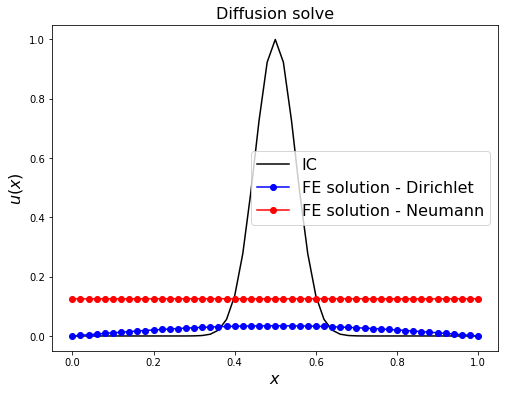

In [151]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$u(x)$', fontsize=16)
ax1.set_title('Diffusion solve', fontsize=16)

ax1.plot(x_nodes, u_ic, 'k-', label='IC')
ax1.plot(x_nodes, Dirichlet_solution, 'bo-', label='FE solution - Dirichlet')
ax1.plot(x_nodes, Neumann_solution, 'ro-', label='FE solution - Neumann')
ax1.legend(loc='best', fontsize=16);

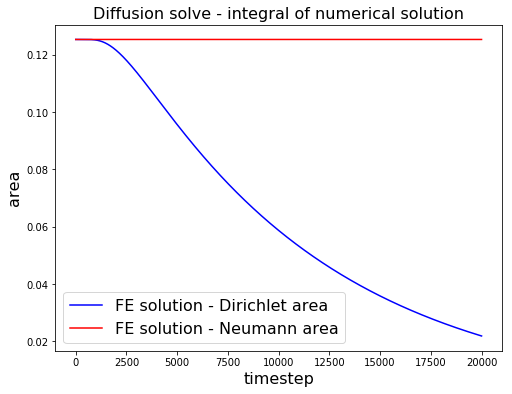

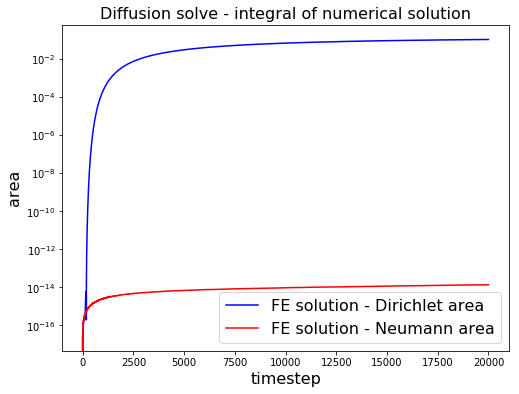

In [152]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('timestep', fontsize=16)
ax1.set_ylabel('area', fontsize=16)
ax1.set_title('Diffusion solve - integral of numerical solution', fontsize=16)


ax1.plot(Dirichlet_area, 'b', label='FE solution - Dirichlet area')
ax1.plot(Neumann_area, 'r', label='FE solution - Neumann area')
ax1.legend(loc='best', fontsize=16);

# log of difference to initial value
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('timestep', fontsize=16)
ax1.set_ylabel('area', fontsize=16)
ax1.set_title('Diffusion solve - integral of numerical solution', fontsize=16)


ax1.semilogy(np.abs(Dirichlet_area - Dirichlet_area[0]), 'b', label='FE solution - Dirichlet area')
ax1.semilogy(np.abs(Neumann_area - Neumann_area[0]), 'r', label='FE solution - Neumann area')
ax1.legend(loc='best', fontsize=16);

## Homework - Laplacian smoothing

Consider the following mesh.

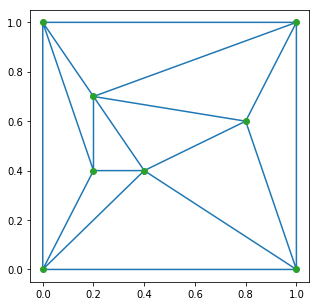

In [110]:
from scipy.spatial import Delaunay

points = np.array([[0.2,0.4],[0.2,0.7], [0.4,0.4], [0.8,0.6]])
# add corners
points = np.concatenate((points,[[0, 0], [0, 1], [1, 0], [1, 1]]))

tri = Delaunay(points, incremental=True)
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(111)

ax1.triplot(points[:, 0], points[:, 1], tri.simplices)
ax1.plot(points[:, 0], points[:, 1], 'o')

Write some code to implement ["Laplacian smoothing"](https://en.wikipedia.org/wiki/Laplacian_smoothing). 

This is an algorithm whereby every vertex of the mesh is visited in turn and its location is relocated to the mean of the locations of the vertices that are connected to it. This process is iterated until convergence. The idea is that this returns a mesh with improved mesh quality (NB. what we mean by quality is a somewhat complex issues but for our purposes we will consider triangles closer to equilateral to be of better quality).

Write a version of this mesh smoother that maintains the locations of the vertices at the four corners (i.e. so that the underlying "geometry" is maintained).

Also since we really do not want elements to go inverted (for vertices to pass through element faces), add an "under-relaxation" parameter that can help with robustness, but does mean we need more iterations. This means that rather than accepting the newly computed location, we choose a new location that is the weighted sum of the current and new positions - for a complex mesh (as in the next part of question) you may need to use a lot of under-relaxation in order to get a good result.

Once this works, test it out on a mesh generated using a Delaunay method (as above) generated from 20 random vertices arranged within the unit square (the use of random points will most likely lead to a "nasty" mesh with elements far from equilateral).  As in the first example add 4 corners which you maintain in their original locations in order to preserve a square geometry.

### Solution - Laplacian smoothing

An ideal solution should turn below into a function, and implement a user-defined stopping criteria rather than iterating for a fixed number of iterations.

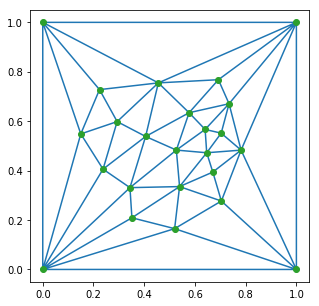

In [114]:
v0 = tri.vertex_neighbor_vertices[0]
v1 = tri.vertex_neighbor_vertices[1]
# under-relaxation parameter
relax = 0.1
for it in range(100):
    for i in range(points.shape[0]-4):
        average = np.mean(points[v1[v0[i]: v0[i+1]]], axis=0)
        # take a weighted sum of old and proposed locations
        points[i, :] = (1-relax)*points[i, :] + relax*average

        
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(111)

ax1.triplot(points[:, 0], points[:, 1], tri.simplices)
ax1.plot(points[:, 0], points[:, 1], 'o')

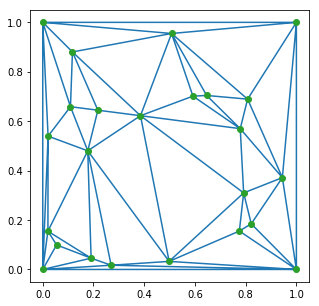

In [115]:
# generate a delaunay mesh from random points

points = np.random.rand(20,2)

# add in corners which we will fix in place to maintain an underlying geometry
points = np.concatenate((points,[[0, 0], [0, 1], [1, 0], [1, 1]]))

tri = Delaunay(points, incremental=True)

fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(111)

ax1.triplot(points[:,0], points[:,1], tri.simplices)
ax1.plot(points[:,0], points[:,1], 'o')


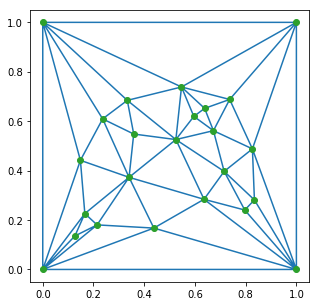

In [116]:
v0 = tri.vertex_neighbor_vertices[0]
v1 = tri.vertex_neighbor_vertices[1]
relax = 0.1
for it in range(1000):
    # don't loop over the 4 corners - could add a "geometry id" to do this in more complex cases
    for i in range(tri.points.shape[0]-4):
        average = np.mean(tri.points[v1[v0[i]: v0[i+1]]], axis=0)
        # take a weighted sum of old and proposed locations
        tri.points[i, :] = (1-relax)*tri.points[i, :] + relax*average

        
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(111)

ax1.triplot(tri.points[:, 0], tri.points[:, 1], tri.simplices)
ax1.plot(tri.points[:, 0], tri.points[:, 1], 'o')